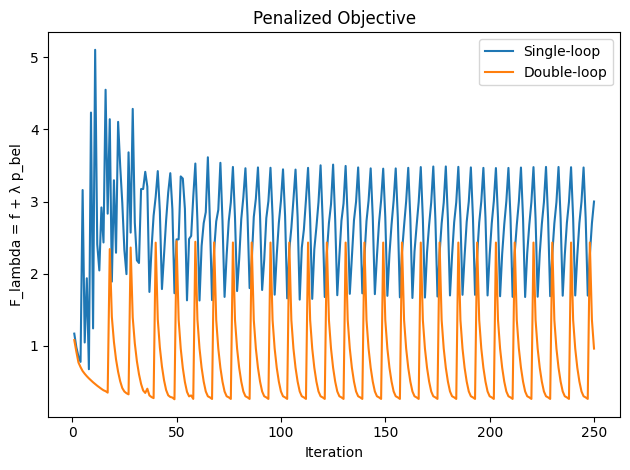

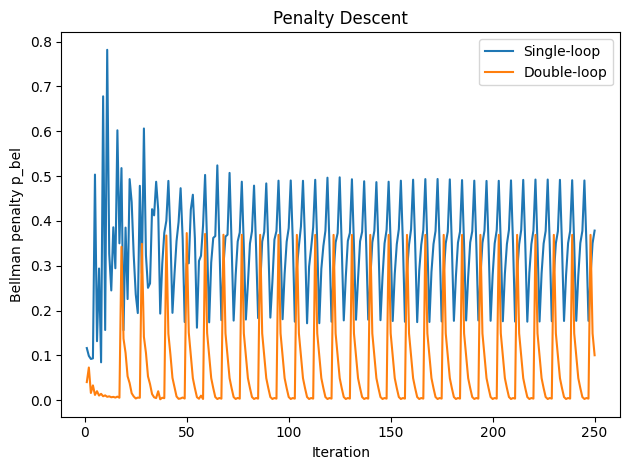

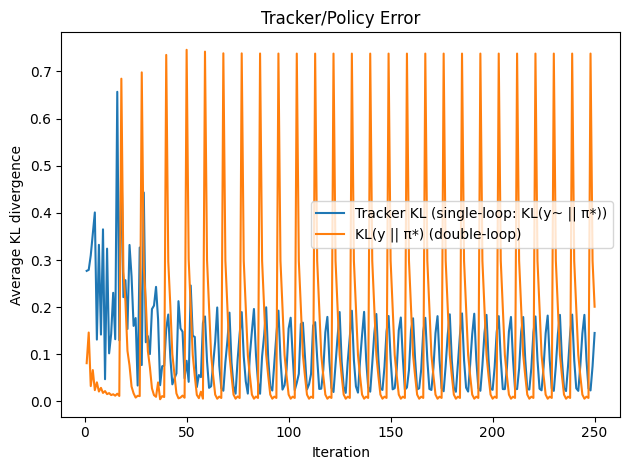

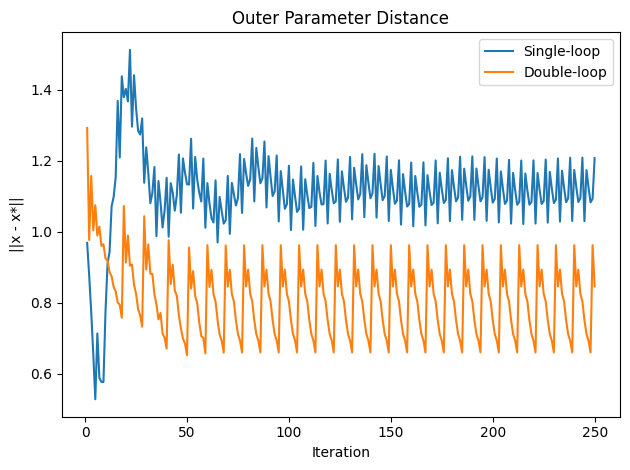

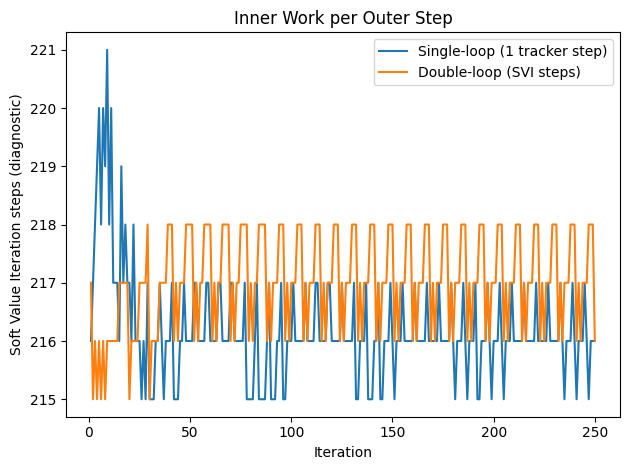

('./pbrl_sl_synthetic_results.csv',
 './pbrl_sl_synthetic_summary.xlsx',
          setup  final_F_lambda  final_p_bel  final_x_dist  avg_trackerKL  \
 0  single-loop        2.999565     0.378383      1.207698       0.113323   
 1  double-loop        0.960911     0.100470      0.846273       0.150593   
 
    total_inner_SVI_steps  
 0                  54047  
 1                  54252  )

In [4]:

import numpy as np
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Optional: nicely display tabular outputs
import pandas as pd
try:
    from ace_tools import display_dataframe_to_user
    HAS_ACE = True
except Exception:
    HAS_ACE = False

np.set_printoptions(precision=4, suppress=True)

# -------------------------
# Utility functions
# -------------------------

def softmax_logits(logits, axis=-1):
    """Stable softmax from logits."""
    m = np.max(logits, axis=axis, keepdims=True)
    e = np.exp(logits - m)
    return e / np.sum(e, axis=axis, keepdims=True)

def project_simplex(v):
    """Euclidean projection of a vector v onto the probability simplex.
    Returns a vector w with w>=0, sum(w)=1.
    """
    # Algorithm from: Duchi, Shalev-Shwartz, Singer, Chandra (ICML 2008)
    if v.ndim == 1:
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u)
        rho = np.nonzero(u * np.arange(1, v.size + 1) > (cssv - 1))[0][-1]
        theta = (cssv[rho] - 1) / (rho + 1.0)
        w = np.maximum(v - theta, 0.0)
        return w
    else:
        # Row-wise projection
        return np.vstack([project_simplex(row) for row in v])

def kl_divergence(p, q, eps=1e-12):
    """KL(p || q) for row-stochastic matrices p and q (same shape)."""
    p_ = np.clip(p, eps, 1.0)
    q_ = np.clip(q, eps, 1.0)
    return np.sum(p_ * (np.log(p_) - np.log(q_)), axis=1)

def entropy(y, eps=1e-12):
    y_ = np.clip(y, eps, 1.0)
    return -np.sum(y_ * np.log(y_), axis=1)  # per-row entropy

# -------------------------
# Synthetic MDP
# -------------------------

@dataclass
class TabularMDP:
    S: int
    A: int
    gamma: float
    tau: float  # entropy-regularization weight (M_tau)
    P: np.ndarray  # (S, A, S)
    base_r: np.ndarray  # (S, A)
    phi: np.ndarray  # (S, A, dx)  (reward features)
    rho: np.ndarray  # (S,) initial-state distribution (full support uniform)
    x_box: float     # box constraint for X: [-x_box, x_box]^dx

def make_synthetic_mdp(seed=0, S=6, A=3, dx=3, gamma=0.9, tau=0.5, x_box=2.0):
    rng = np.random.default_rng(seed)
    # Build ergodic transitions by convex-combining a random stochastic matrix with a rank-1 mixing matrix
    P = np.zeros((S, A, S))
    for a in range(A):
        R = rng.random((S, S))
        R = R / R.sum(axis=1, keepdims=True)
        # Mix with a uniform kernel to guarantee ergodicity
        mix = 0.15
        P[:, a, :] = (1 - mix) * R + mix * (np.ones((S, S)) / S)

    # Base rewards and features
    base_r = rng.normal(loc=0.0, scale=0.3, size=(S, A))  # small random base reward
    phi = rng.normal(loc=0.0, scale=1.0, size=(S, A, dx))  # reward features

    rho = np.ones(S) / S
    return TabularMDP(S=S, A=A, gamma=gamma, tau=tau, P=P, base_r=base_r, phi=phi, rho=rho, x_box=x_box)

# -------------------------
# Core RL primitives for M_tau(x)
# -------------------------

def rewards_from_x(mdp: TabularMDP, x: np.ndarray):
    # r_x(s,a) = base_r(s,a) + phi(s,a)·x
    return mdp.base_r + np.tensordot(mdp.phi, x, axes=([2], [0]))  # (S, A)

def policy_evaluation_entropy_reg(mdp: TabularMDP, r: np.ndarray, pi: np.ndarray):
    """Compute V^pi for M_tau(x) with entropy regularization: V = r_pi - tau * H(pi) + gamma P_pi V.
    Returns V, Q for the given (r, pi).
    """
    S, A = mdp.S, mdp.A
    # Build P_pi
    P_pi = np.einsum('sa,sat->st', pi, mdp.P)
    # r_bar(s) = E_a r(s,a)
    r_bar = np.einsum('sa,sa->s', pi, r)
    # h_vec(s) = h(pi(s)) where h is negative entropy => h(y)=sum y log y; note V uses -tau h, so subtract tau*h
    # negative entropy h = sum y log y
    eps = 1e-12
    h_vec = np.sum(np.clip(pi, eps, 1) * np.log(np.clip(pi, eps, 1)), axis=1)

    # Solve (I - gamma P_pi) V = r_bar - tau * h_vec
    I = np.eye(S)
    b = r_bar - mdp.tau * h_vec
    V = np.linalg.solve(I - mdp.gamma * P_pi, b)
    # Q(s,a) = r(s,a) + gamma * P(s,a,:) @ V
    Q = r + mdp.gamma * np.einsum('sat,t->sa', mdp.P, V)
    return V, Q

def soft_value_iteration_optimal(mdp: TabularMDP, r: np.ndarray, tol=1e-10, max_it=5000):
    """Compute soft-optimal V*, Q*, and pi* for M_tau(x):
       V(s) = tau * log sum_a exp(Q(s,a)/tau), Q(s,a) = r(s,a) + gamma E_{s'} V(s').
    """
    S, A = mdp.S, mdp.A
    V = np.zeros(S)
    for it in range(max_it):
        Q = r + mdp.gamma * np.einsum('sat,t->sa', mdp.P, V)
        V_new = mdp.tau * np.log(np.sum(np.exp(Q / mdp.tau), axis=1))
        if np.max(np.abs(V_new - V)) < tol:
            V = V_new
            break
        V = V_new
    Q = r + mdp.gamma * np.einsum('sat,t->sa', mdp.P, V)
    pi_star = softmax_logits(Q / mdp.tau, axis=1)
    return V, Q, pi_star, it + 1

def grad_x_V_and_Q(mdp: TabularMDP, pi: np.ndarray):
    """Compute ∇_x V^pi and ∇_x Q^pi for M_tau(x) when r_x(s,a) = base_r + phi·x and P does not depend on x.
       ∇_x V = (I - gamma P_pi)^{-1} Φ̄_pi
       ∇_x Q(s,a) = φ(s,a) + gamma P(s,a,:) @ ∇_x V.
       Returns:
         G_V: (S, dx)
         G_Q: (S, A, dx)
    """
    S, A, dx = mdp.S, mdp.A, mdp.phi.shape[2]
    P_pi = np.einsum('sa,sat->st', pi, mdp.P)
    # Φ̄_pi(s,:) = E_a[phi(s,a,:)]
    Phi_bar = np.einsum('sa,sad->sd', pi, mdp.phi)  # (S, dx)
    I = np.eye(S)
    G_V = np.linalg.solve(I - mdp.gamma * P_pi, Phi_bar)  # (S, dx)
    # G_Q(s,a,:) = phi(s,a,:) + gamma * sum_{s'} P(s,a,s') * G_V(s',:)
    G_Q = mdp.phi + mdp.gamma * np.einsum('sat,td->sad', mdp.P, G_V)  # (S, A, dx)
    return G_V, G_Q

# -------------------------
# Bellman penalty pieces
# -------------------------

def bellman_penalty_value(mdp: TabularMDP, r: np.ndarray, y: np.ndarray):
    """Compute p_bel(x,y) = g(x,y) - v(x).
       g(x,y) = E_s [ <y_s, q_s(x)> + tau h(y_s) ], where q_s(x) = - Q^{pi*}(s,:).
       v(x)    = min_y g(x,y) = E_s [ - tau * log sum_a exp(Q^{pi*}(s,a)/tau) ].
       Returns p_bel, and auxiliary (Q_star, pi_star, iters).
    """
    V_star, Q_star, pi_star, iters = soft_value_iteration_optimal(mdp, r)
    q = -Q_star
    # negative entropy h(y) = sum y log y
    eps = 1e-12
    h_y = np.sum(np.clip(y, eps, 1) * np.log(np.clip(y, eps, 1)), axis=1)  # per-state
    g = np.mean(np.sum(y * q, axis=1) + mdp.tau * h_y)  # average over s using uniform rho
    v = np.mean(- mdp.tau * np.log(np.sum(np.exp(Q_star / mdp.tau), axis=1)))
    p_bel = g - v
    return p_bel, (Q_star, pi_star, iters)

def tracker_step_pmd(mdp: TabularMDP, x: np.ndarray, y_tilde: np.ndarray, beta: float):
    """One PMD/PG tracker step (Algorithm 1, line 4) with negative-entropy mirror map.
       y_tilde_next(s,:) ∝ y_tilde(s,:)^(1/(1+beta*tau)) * exp( [beta/(1+beta*tau)] * Q_{y_tilde}(s,:) )
    """
    r = rewards_from_x(mdp, x)
    _, Q_tilde = policy_evaluation_entropy_reg(mdp, r, y_tilde)  # Q under current tracker policy
    c1 = 1.0 / (1.0 + beta * mdp.tau)
    c2 = beta / (1.0 + beta * mdp.tau)
    # Update per state
    logits = c2 * Q_tilde + c1 * np.log(np.clip(y_tilde, 1e-12, 1.0))
    y_tilde_next = softmax_logits(logits, axis=1)
    return y_tilde_next, Q_tilde

def penalty_grad_estimators(mdp: TabularMDP, x: np.ndarray, y: np.ndarray, y_tilde_next: np.ndarray):
    """Algorithm 1, line 5: plug-in estimators for ∇_x p_bel and ∇_y p_bel, substituting pi* with y_tilde_next.
       Returns:
         grad_x_hat: (dx,)    -- expectation over rho
         grad_y_hat: (S,A)    -- per-state gradient weighted by rho
    """
    r = rewards_from_x(mdp, x)
    # ∇_y estimator needs Q under y_tilde_next
    _, Q_ytilde = policy_evaluation_entropy_reg(mdp, r, y_tilde_next)
    # ∇_x estimator uses G_Q under y_tilde_next
    _, G_Q = grad_x_V_and_Q(mdp, y_tilde_next)  # (S,A,dx)

    # Expectation over rho (uniform): sum_s (1/S) sum_a [ (y_tilde_next - y) * G_Q(s,a,:) ]
    diff = y_tilde_next - y  # (S,A)
    grad_x_hat = np.einsum('sa,sad->d', diff, G_Q) / mdp.S  # (dx,)

    # ∇_y pbel_hat(s, :) = - Q_{y_tilde_next}(s,:) + tau * ∇h(y(s,:)), and then average over rho
    eps = 1e-12
    grad_h = 1.0 + np.log(np.clip(y, eps, 1.0))  # gradient of negative entropy per state
    grad_y_hat = (-Q_ytilde + mdp.tau * grad_h) / mdp.S  # distribute rho=uniform
    return grad_x_hat, grad_y_hat

def outer_projected_step(mdp: TabularMDP, x, y, grad_x, grad_y, alpha):
    """Euclidean projected step on X×Y. X is a box, Y is per-state simplex."""
    x_new = x - alpha * grad_x
    x_new = np.clip(x_new, -mdp.x_box, mdp.x_box)
    y_new = y - alpha * grad_y
    # Project each state's row to simplex
    for s in range(mdp.S):
        y_new[s, :] = project_simplex(y_new[s, :])
    return x_new, y_new

# -------------------------
# Algorithms
# -------------------------

def run_pbrl_sl(mdp: TabularMDP, K=200, alpha=0.1, beta=0.2, lam=5.0, seed=0):
    rng = np.random.default_rng(seed)
    dx = mdp.phi.shape[2]

    # Initialize x, y, y_tilde
    x = rng.normal(scale=0.5, size=(dx,))
    # initialize y and ytilde as uniform policies
    y = np.ones((mdp.S, mdp.A)) / mdp.A
    y_tilde = np.ones((mdp.S, mdp.A)) / mdp.A

    # Outer objective f(x) = 0.5 * ||x - x_target||^2 (smooth), no dependence on y for simplicity
    x_target = np.ones(dx) * 0.7

    history = {
        "iter": [],
        "F_lambda": [],
        "p_bel": [],
        "tracker_KL": [],
        "x_dist": [],
        "inner_cost_value_iter": [],  # per-iter soft-value-iteration steps to get pi* (just for logging/diagnostics)
    }

    total_value_iter = 0
    for k in range(1, K + 1):
        # Tracker step
        y_tilde_next, Q_tilde = tracker_step_pmd(mdp, x, y_tilde, beta=beta)

        # Grad estimators
        grad_x_hat, grad_y_hat = penalty_grad_estimators(mdp, x, y, y_tilde_next)

        # Outer f pieces
        grad_f_x = (x - x_target)
        grad_f_y = np.zeros_like(y)

        # Outer projected step
        x, y = outer_projected_step(mdp, x, y, grad_f_x + lam * grad_x_hat, grad_f_y + lam * grad_y_hat, alpha=alpha)

        # Move tracker forward
        y_tilde = y_tilde_next

        # Diagnostics: compute exact Bellman penalty and soft-optimal policy for current x
        r = rewards_from_x(mdp, x)
        p_bel, (Q_star, pi_star, iters) = bellman_penalty_value(mdp, r, y)
        total_value_iter += iters

        # Tracker error: average KL(y_tilde || pi_star)
        kl = kl_divergence(y_tilde, pi_star)  # per state
        tracker_kl = kl.mean()

        # F_lambda
        f_val = 0.5 * np.sum((x - x_target) ** 2)
        F_lambda = f_val + lam * p_bel

        history["iter"].append(k)
        history["F_lambda"].append(float(F_lambda))
        history["p_bel"].append(float(p_bel))
        history["tracker_KL"].append(float(tracker_kl))
        history["x_dist"].append(float(np.linalg.norm(x - x_target)))
        history["inner_cost_value_iter"].append(iters)

    history["total_value_iter"] = total_value_iter
    return x, y, y_tilde, history

def run_double_loop_baseline(mdp: TabularMDP, K=200, alpha=0.1, lam=5.0, seed=1):
    rng = np.random.default_rng(seed)
    dx = mdp.phi.shape[2]
    x = rng.normal(scale=0.5, size=(dx,))
    y = np.ones((mdp.S, mdp.A)) / mdp.A

    x_target = np.ones(dx) * 0.7

    history = {
        "iter": [],
        "F_lambda": [],
        "p_bel": [],
        "tracker_KL": [],  # N/A but we log KL to pi* for parity (set to KL(y||pi*))
        "x_dist": [],
        "inner_cost_value_iter": [],  # exact inner solve cost per outer step
    }

    total_value_iter = 0
    for k in range(1, K + 1):
        # Inner best response: compute exact pi*(x) by soft value iteration
        r = rewards_from_x(mdp, x)
        _, Q_star, pi_star, iters = soft_value_iteration_optimal(mdp, r)
        total_value_iter += iters

        # Plug pi* into the same estimators (line 5)
        # ∇_y estimator
        eps = 1e-12
        grad_h = 1.0 + np.log(np.clip(y, eps, 1.0))
        grad_y_hat = (-Q_star + mdp.tau * grad_h) / mdp.S

        # ∇_x estimator with G_Q computed at pi*:
        _, G_Q = grad_x_V_and_Q(mdp, pi_star)
        diff = pi_star - y
        grad_x_hat = np.einsum('sa,sad->d', diff, G_Q) / mdp.S

        # Outer step
        grad_f_x = (x - x_target)
        grad_f_y = np.zeros_like(y)
        x, y = outer_projected_step(mdp, x, y, grad_f_x + lam * grad_x_hat, grad_f_y + lam * grad_y_hat, alpha=alpha)

        # Diagnostics
        r = rewards_from_x(mdp, x)
        p_bel, (Q_star2, pi_star2, _iters2) = bellman_penalty_value(mdp, r, y)
        kl_y_pi = kl_divergence(y, pi_star2).mean()
        f_val = 0.5 * np.sum((x - x_target) ** 2)
        F_lambda = f_val + lam * p_bel

        history["iter"].append(k)
        history["F_lambda"].append(float(F_lambda))
        history["p_bel"].append(float(p_bel))
        history["tracker_KL"].append(float(kl_y_pi))
        history["x_dist"].append(float(np.linalg.norm(x - x_target)))
        history["inner_cost_value_iter"].append(iters)

    history["total_value_iter"] = total_value_iter
    return x, y, history

# -------------------------
# Run experiments
# -------------------------

mdp = make_synthetic_mdp(seed=42, S=6, A=3, dx=3, gamma=0.9, tau=0.5, x_box=2.0)

K = 250
alpha = 0.12
beta = 0.25
lam = 6.0

x_sl, y_sl, ytilde_sl, hist_sl = run_pbrl_sl(mdp, K=K, alpha=alpha, beta=beta, lam=lam, seed=0)
x_dl, y_dl, hist_dl = run_double_loop_baseline(mdp, K=K, alpha=alpha, lam=lam, seed=1)

# -------------------------
# Prepare results table
# -------------------------

df = pd.DataFrame({
    "iter": hist_sl["iter"],
    "F_lambda_single": hist_sl["F_lambda"],
    "p_bel_single": hist_sl["p_bel"],
    "trackerKL_single": hist_sl["tracker_KL"],
    "x_dist_single": hist_sl["x_dist"],
    "F_lambda_double": hist_dl["F_lambda"],
    "p_bel_double": hist_dl["p_bel"],
    "trackerKL_double": hist_dl["tracker_KL"],
    "x_dist_double": hist_dl["x_dist"],
    "innerCost_valueIter_single": hist_sl["inner_cost_value_iter"],
    "innerCost_valueIter_double": hist_dl["inner_cost_value_iter"],
})

# Export
csv_path = "./pbrl_sl_synthetic_results.csv"
df.to_csv(csv_path, index=False)

# -------------------------
# Plots (one chart per figure; no explicit colors)
# -------------------------

# F_lambda
plt.figure()
plt.plot(df["iter"], df["F_lambda_single"], label="Single-loop")
plt.plot(df["iter"], df["F_lambda_double"], label="Double-loop")
plt.xlabel("Iteration")
plt.ylabel("F_lambda = f + λ p_bel")
plt.title("Penalized Objective")
plt.legend()
plt.tight_layout()
plt.show()

# p_bel
plt.figure()
plt.plot(df["iter"], df["p_bel_single"], label="Single-loop")
plt.plot(df["iter"], df["p_bel_double"], label="Double-loop")
plt.xlabel("Iteration")
plt.ylabel("Bellman penalty p_bel")
plt.title("Penalty Descent")
plt.legend()
plt.tight_layout()
plt.show()

# tracker KL
plt.figure()
plt.plot(df["iter"], df["trackerKL_single"], label="Tracker KL (single-loop: KL(y~ || π*))")
plt.plot(df["iter"], df["trackerKL_double"], label="KL(y || π*) (double-loop)")
plt.xlabel("Iteration")
plt.ylabel("Average KL divergence")
plt.title("Tracker/Policy Error")
plt.legend()
plt.tight_layout()
plt.show()

# x distance
plt.figure()
plt.plot(df["iter"], df["x_dist_single"], label="Single-loop")
plt.plot(df["iter"], df["x_dist_double"], label="Double-loop")
plt.xlabel("Iteration")
plt.ylabel("||x - x*||")
plt.title("Outer Parameter Distance")
plt.legend()
plt.tight_layout()
plt.show()

# Inner cost per outer iteration (value-iteration steps)
plt.figure()
plt.plot(df["iter"], df["innerCost_valueIter_single"], label="Single-loop (1 tracker step)")
plt.plot(df["iter"], df["innerCost_valueIter_double"], label="Double-loop (SVI steps)")
plt.xlabel("Iteration")
plt.ylabel("Soft Value Iteration steps (diagnostic)")
plt.title("Inner Work per Outer Step")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------
# Summaries
# -------------------------

summary = pd.DataFrame({
    "setup": ["single-loop", "double-loop"],
    "final_F_lambda": [df["F_lambda_single"].iloc[-1], df["F_lambda_double"].iloc[-1]],
    "final_p_bel": [df["p_bel_single"].iloc[-1], df["p_bel_double"].iloc[-1]],
    "final_x_dist": [df["x_dist_single"].iloc[-1], df["x_dist_double"].iloc[-1]],
    "avg_trackerKL": [df["trackerKL_single"].mean(), df["trackerKL_double"].mean()],
    "total_inner_SVI_steps": [hist_sl["total_value_iter"], hist_dl["total_value_iter"]],
})
xlsx_path = "./pbrl_sl_synthetic_summary.xlsx"
summary.to_excel(xlsx_path, index=False)

if HAS_ACE:
    display_dataframe_to_user("PBRL-SL synthetic: iteration log", df)
    display_dataframe_to_user("PBRL-SL synthetic: summary", summary)

csv_path, xlsx_path, summary.head(2)


In [5]:
import pandas as pd

csv_path = "./pbrl_sl_synthetic_results.csv"
xlsx_path = "./pbrl_sl_synthetic_summary.xlsx"

df = pd.read_csv(csv_path)
summary = pd.read_excel(xlsx_path)

print("Saved files:")
print(" - Results CSV:", csv_path)
print(" - Summary XLSX:", xlsx_path)
print("\nSummary (last 2 rows shown):")
print(summary.tail(2))


Saved files:
 - Results CSV: ./pbrl_sl_synthetic_results.csv
 - Summary XLSX: ./pbrl_sl_synthetic_summary.xlsx

Summary (last 2 rows shown):
         setup  final_F_lambda  final_p_bel  final_x_dist  avg_trackerKL  \
0  single-loop        2.999565     0.378383      1.207698       0.113323   
1  double-loop        0.960911     0.100470      0.846273       0.150593   

   total_inner_SVI_steps  
0                  54047  
1                  54252  


In [7]:
import pandas as pd

df = pd.read_csv("./pbrl_sl_synthetic_results.csv")

init_F_single = df["F_lambda_single"].iloc[0]
final_F_single = df["F_lambda_single"].iloc[-1]
init_p_single = df["p_bel_single"].iloc[0]
final_p_single = df["p_bel_single"].iloc[-1]

init_F_double = df["F_lambda_double"].iloc[0]
final_F_double = df["F_lambda_double"].iloc[-1]
init_p_double = df["p_bel_double"].iloc[0]
final_p_double = df["p_bel_double"].iloc[-1]

print("Single-loop: F_lambda {:.3f} -> {:.3f}, p_bel {:.3f} -> {:.3f}".format(
    init_F_single, final_F_single, init_p_single, final_p_single
))
print("Double-loop: F_lambda {:.3f} -> {:.3f}, p_bel {:.3f} -> {:.3f}".format(
    init_F_double, final_F_double, init_p_double, final_p_double
))


Single-loop: F_lambda 1.168 -> 3.000, p_bel 0.117 -> 0.378
Double-loop: F_lambda 1.079 -> 0.961, p_bel 0.041 -> 0.100


Saved: ./pbrl_sl_synthetic_results_run2.csv
Single-loop: F_lambda 1.007 -> 0.352, p_bel 0.066 -> 0.065
Double-loop: F_lambda 2.098 -> 0.530, p_bel 0.089 -> 0.102


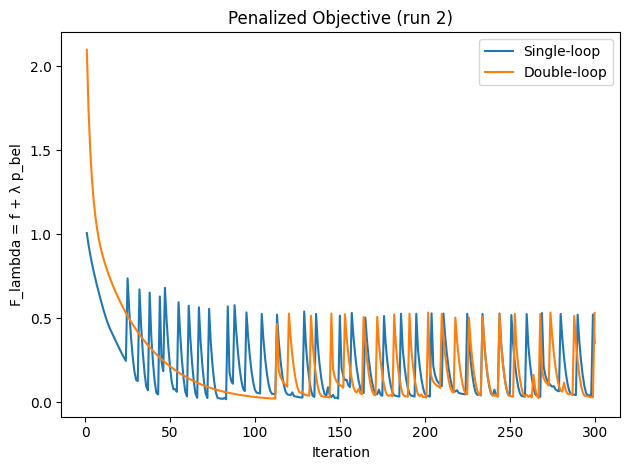

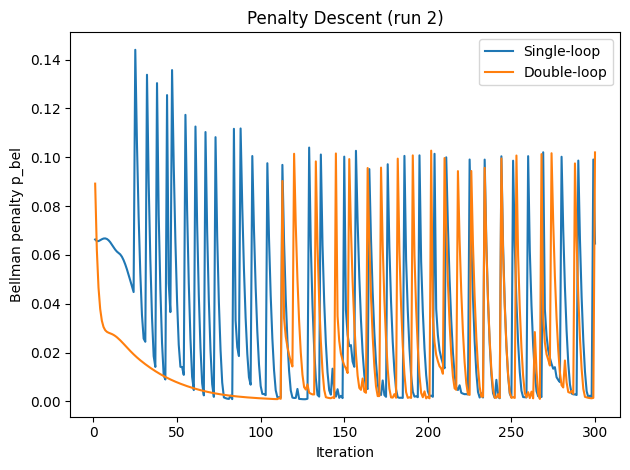

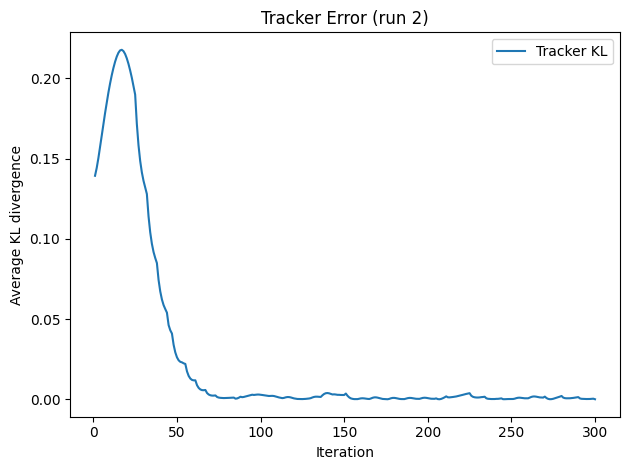

In [8]:
# Let's rerun with more conservative stepsizes to stabilize the single-loop method,
# as suggested by Theorem 1 (smaller alpha when λ is larger, and beta ≈ τ/(C_J λ)).

mdp = make_synthetic_mdp(seed=123, S=6, A=3, dx=3, gamma=0.9, tau=0.5, x_box=2.0)

K = 300
alpha = 0.05   # smaller outer step
beta = 0.08    # smaller tracker step
lam = 5.0

x_sl2, y_sl2, ytilde_sl2, hist_sl2 = run_pbrl_sl(mdp, K=K, alpha=alpha, beta=beta, lam=lam, seed=7)
x_dl2, y_dl2, hist_dl2 = run_double_loop_baseline(mdp, K=K, alpha=alpha, lam=lam, seed=9)

import pandas as pd
df2 = pd.DataFrame({
    "iter": hist_sl2["iter"],
    "F_lambda_single": hist_sl2["F_lambda"],
    "p_bel_single": hist_sl2["p_bel"],
    "trackerKL_single": hist_sl2["tracker_KL"],
    "x_dist_single": hist_sl2["x_dist"],
    "F_lambda_double": hist_dl2["F_lambda"],
    "p_bel_double": hist_dl2["p_bel"],
    "trackerKL_double": hist_dl2["tracker_KL"],
    "x_dist_double": hist_dl2["x_dist"],
})
csv_path2 = "./pbrl_sl_synthetic_results_run2.csv"
df2.to_csv(csv_path2, index=False)

print("Saved:", csv_path2)

# Headline stats
print("Single-loop: F_lambda {:.3f} -> {:.3f}, p_bel {:.3f} -> {:.3f}".format(
    df2["F_lambda_single"].iloc[0], df2["F_lambda_single"].iloc[-1],
    df2["p_bel_single"].iloc[0], df2["p_bel_single"].iloc[-1]
))
print("Double-loop: F_lambda {:.3f} -> {:.3f}, p_bel {:.3f} -> {:.3f}".format(
    df2["F_lambda_double"].iloc[0], df2["F_lambda_double"].iloc[-1],
    df2["p_bel_double"].iloc[0], df2["p_bel_double"].iloc[-1]
))

# Plots
plt.figure()
plt.plot(df2["iter"], df2["F_lambda_single"], label="Single-loop")
plt.plot(df2["iter"], df2["F_lambda_double"], label="Double-loop")
plt.xlabel("Iteration")
plt.ylabel("F_lambda = f + λ p_bel")
plt.title("Penalized Objective (run 2)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df2["iter"], df2["p_bel_single"], label="Single-loop")
plt.plot(df2["iter"], df2["p_bel_double"], label="Double-loop")
plt.xlabel("Iteration")
plt.ylabel("Bellman penalty p_bel")
plt.title("Penalty Descent (run 2)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df2["iter"], df2["trackerKL_single"], label="Tracker KL")
plt.xlabel("Iteration")
plt.ylabel("Average KL divergence")
plt.title("Tracker Error (run 2)")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Report inner work (algorithmic). For the baseline, it's the SVI steps we took to get pi* at each outer step.
avg_svi_steps_baseline = np.mean(hist_dl2["inner_cost_value_iter"])
print("Baseline (double-loop) average SVI steps per outer iteration:", float(avg_svi_steps_baseline))

# For the single-loop method, the algorithmic inner work is *one* PMD step per outer iteration by design.
print("Single-loop uses exactly 1 tracker (PMD) step per outer iteration (no inner best-response).")


Baseline (double-loop) average SVI steps per outer iteration: 221.23666666666668
Single-loop uses exactly 1 tracker (PMD) step per outer iteration (no inner best-response).
